In [1]:

import os
from detanet_model import *

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')

dataset = []
spec_data = []

# Load the dataset
dataset = torch.load(os.path.join(data_dir, 'HOPV_241pol.pt'))
print(f"Number of graphs in the dataset: {len(dataset)}")

print(f"Total dataset length: {len(dataset)}")

ex1 = dataset[0]
ex2 = dataset[5]

print("dataset[0] :", ex1, )
print("dataset[5] :", ex2,)

for data in dataset:
    data.real_ee = data.real_ee
    data.imag_ee = data.imag_ee
    data.y = torch.cat([data.real_ee, data.imag_ee], dim=0)
    data.spectra = data.spectra[1:]
    data.x = data.spectra.repeat(len(data.z), 1)


ex1 = dataset[0]
print("dataset[0] :", ex1, )

Number of graphs in the dataset: 347
Total dataset length: 347
dataset[0] : Data(pos=[68, 3], idx='HOPV_0', dataset_name='HOPV', smiles='Cc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c6cc(S(C)(=O)=O)sc65)s4)sc3c(-c3ccc(C)s3)c3ccsc32)s1', z=[68], freqs=[242], spectra=[242], real_ee=[242, 3, 3], imag_ee=[242, 3, 3], real_em=[242, 3, 3], imag_em=[242, 3, 3], real_mm=[242, 3, 3], imag_mm=[242, 3, 3], osc_pos=[40], osc_strength=[40])
dataset[5] : Data(pos=[55, 3], idx='HOPV_5', dataset_name='HOPV', smiles='C#Cc1cc(OC)c(C#Cc2scc3nc(-c4ccccc4)c(-c4ccccc4)nc32)cc1OC', z=[55], freqs=[242], spectra=[242], real_ee=[242, 3, 3], imag_ee=[242, 3, 3], real_em=[242, 3, 3], imag_em=[242, 3, 3], real_mm=[242, 3, 3], imag_mm=[242, 3, 3], osc_pos=[40], osc_strength=[40])
dataset[0] : Data(pos=[68, 3], idx='HOPV_0', dataset_name='HOPV', smiles='Cc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c6cc(S(C)(=O)=O)sc65)s4)sc3c(-c3ccc(C)s3)c3ccsc32)s1', z=[68], freqs=[242], spectra=[241], real_ee=[242, 3, 3], imag_ee=[242, 3, 3], rea

In [2]:

# -------------------------------
# Shuffle & Train/Val Split
# -------------------------------
import random
random.seed(3512)
random.shuffle(dataset)
train_frac = 0.9
split_index = int(train_frac * len(dataset))

train_datasets = dataset[:split_index]
val_datasets   = dataset[split_index:]


In [3]:
# -------------------------------
# Create Model
# -------------------------------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = DetaNet(num_features=512,
                    act='swish',
                    maxl=3,
                    num_block=4, #3
                    radial_type='trainable_bessel',
                    num_radial=32,
                    attention_head=64,
                    rc=4,
                    dropout=0.0,
                    use_cutoff=False,
                    max_atomic_number=34,
                    atom_ref=None,
                    scale=1.0,
                    scalar_outsize=(4*241), # 2,#4, 
                    irreps_out= '482x2e', #'2e',# '2e+2e',
                    summation=True,
                    norm=False,
                    out_type='multi_tensor',
                    grad_type=None,
                    x_features=241,
                    device=device)


params='/home/maria/dyn-detanet/code/trained_param/HOPV241_Shifted0.2Dropout_241spectra100epochs_16batchsize_0.0005lr_4cutoff_4numblock_512features_64att_HOPV_241pol_seed3512.pth'
state_dict = torch.load(params)
model.to(device)
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch


def plot_polarizability_elements(data_entry, model, out_dir="."):
    """
    Plot ground-truth and predicted polarizability spectra (real + imag) for one molecule
    in a 1×6 layout and place a single legend in the top-right corner of each figure.
    """

    import matplotlib.pyplot as plt      # keep this import
    plt.style.use("seaborn-v0_8-whitegrid")

    plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],
    "font.size": 16  # base font size for ticks and text
    })


    # ------------------------------------------------------------------
    # 1.  Ground-truth tensors
    # ------------------------------------------------------------------
    mol_idx   = data_entry.idx
    real_list = np.asarray(data_entry.real_ee)          # [N+1, 3, 3]
    imag_list = np.asarray(data_entry.imag_ee)          # [N+1, 3, 3]

    static_pol = real_list[0]
    real_list  = real_list[1:]  # remove static polarizability
    imag_list  = imag_list[1:]
    N = real_list.shape[0]

    # ------------------------------------------------------------------
    # 2.  Model prediction
    # ------------------------------------------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = model.to(device).eval()
    with torch.no_grad():
        pol_spec = model(
            z=data_entry.z.to(device),
            pos=data_entry.pos.to(device),
            x_features=data_entry.x.to(device)
        ).cpu().numpy()                                # [N_real+N_imag, 3, 6]

    half            = pol_spec.shape[0] // 2
    pred_pol_real   = pol_spec[:half]
    pred_pol_imag   = pol_spec[half:]

    for k in range(N):
        pred_pol_real[k] += static_pol                 # add α(0) to each slice

    # ------------------------------------------------------------------
    # 3.  Plot settings
    # ------------------------------------------------------------------
    #pairs   = [(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]
    #labels  = ["xx", "xy", "xz", "yy", "yz", "zz"]
    #nrows, ncols = 1, 6

    # NEW ➊–➌
    pairs   = [(0, 0), (1, 1), (2, 2)]        # ➊ only diagonal components
    labels  = ["xx", "yy", "zz"]               # ➋ matching titles
    nrows, ncols = 1, 3                        # ➌ 1×3 layout instead of 1×6

    gt_kwargs      = dict(marker='o', color='royalblue', s=10, alpha=0.6)
    gt_kwargs_imag = dict(marker='o', color='orange',   s=10, alpha=0.8)
    pred_kwargs    = dict(marker='^', color='black',      s=6,  alpha=0.6)

    rmin = min(real_list.min(), pred_pol_real.min()) - 20
    rmax = max(real_list.max(), pred_pol_real.max()) + 20
    imin = min(imag_list.min(), pred_pol_imag.min()) - 20
    imax = max(imag_list.max(), pred_pol_imag.max()) + 20

    # ------------------------------------------------------------------
    # 4.  Real-part figure (1×6)
    # ------------------------------------------------------------------
    fig_r, axes_r = plt.subplots(nrows, ncols, figsize=(15, 4.5), sharey=True)
    #fig_r.suptitle(f"Polarizability (Real) – Mol idx={mol_idx}", fontsize=14)

    for idx, (i, j) in enumerate(pairs):
        ax = axes_r[idx]
        print(len(data_entry.freqs), len(real_list[:, i, j]), len(pred_pol_real[:, i, j]))
        ax.scatter(data_entry.freqs[1:], real_list[:, i, j],  label="GT",  **gt_kwargs)
        ax.scatter(data_entry.freqs[1:], pred_pol_real[:, i, j], label="Prediction", **pred_kwargs)
        ax.set_title(f"{labels[idx]}")
        ax.set_ylim(rmin, rmax)
        ax.grid(True)

    # global labels
    fig_r.text(0.5, 0.04, "Frequency (eV)", ha="center", va="center", fontsize=22)
    fig_r.text(0.05, 0.5, "α-Real (a. u.)",      ha="center", va="center",
               rotation="vertical", fontsize=22)

    # collect handles from first axis and add a single legend
    handles, lbls = axes_r[0].get_legend_handles_labels()
    fig_r.legend(handles, lbls, loc="upper right", bbox_to_anchor=(0.97, 0.85), fontsize=22,  markerscale=3.0, 
                frameon=True,
                facecolor="white",
                edgecolor="0.7",
                framealpha=0.8)
    plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.93])
    os.makedirs(out_dir, exist_ok=True)
    fig_r.savefig(os.path.join(
        out_dir, f"polar_elements_real_{mol_idx}_{data_entry.dataset_name}.png"
    ), dpi=300)
    plt.show()
    plt.close(fig_r)

    # ------------------------------------------------------------------
    # 5.  Imaginary-part figure (1×6)
    # ------------------------------------------------------------------
    fig_i, axes_i = plt.subplots(nrows, ncols, figsize=(15, 4.5), sharey=True)
    #fig_i.suptitle(f"Polarizability (Imag) – Mol idx={mol_idx}", fontsize=14)

    for idx, (i, j) in enumerate(pairs):
        ax = axes_i[idx]
        print("imag", len(data_entry.freqs), len(imag_list[:, i, j]), len(pred_pol_imag[:, i, j]))
        ax.scatter(data_entry.freqs[1:], imag_list[:, i, j], label="GT",  **gt_kwargs_imag)
        ax.scatter(data_entry.freqs[1:], pred_pol_imag[:, i, j], label="Prediction", **pred_kwargs)
        ax.set_title(f"{labels[idx]}")
        ax.set_ylim(imin, imax)
        ax.grid(True)

    fig_i.text(0.5, 0.04, "Frequency (eV)", ha="center", va="center", fontsize=22)
    fig_i.text(0.05, 0.5, "α-Imag (a. u.)",      ha="center", va="center",
               rotation="vertical", fontsize=22)

    handles_i, lbls_i = axes_i[0].get_legend_handles_labels()
    fig_i.legend(handles_i, lbls_i, loc="upper right", bbox_to_anchor=(0.97, 0.85), fontsize=22,  markerscale=3.0, 
                frameon=True,
                facecolor="white",
                edgecolor="0.7",
                framealpha=0.8)

    plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.93])
    fig_i.savefig(os.path.join(
        out_dir, f"polar_elements_imag_{mol_idx}_{data_entry.dataset_name}.png"
    ), dpi=300)
    plt.show()
    plt.close(fig_i)


242 241 241
242 241 241
242 241 241


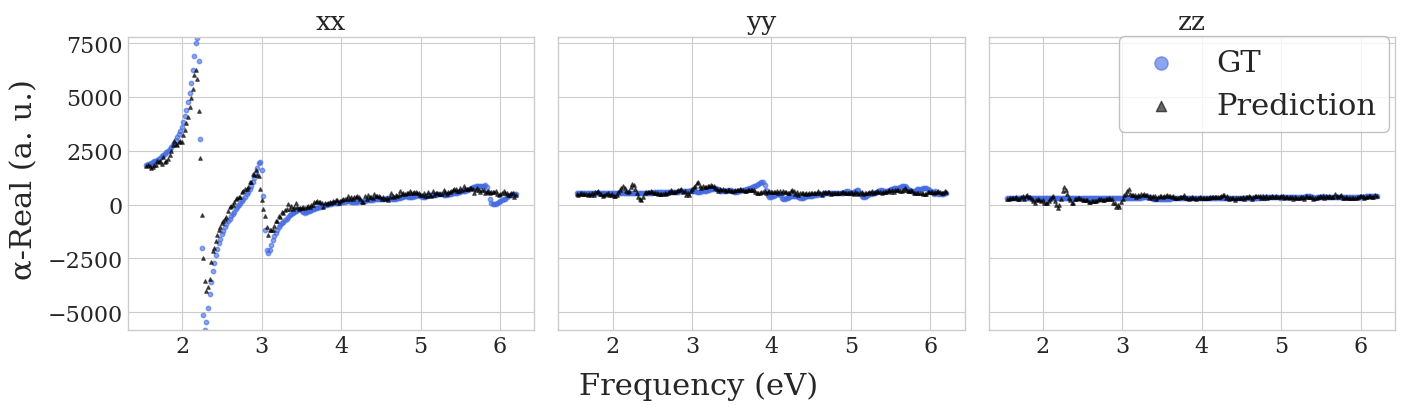

imag 242 241 241
imag 242 241 241
imag 242 241 241


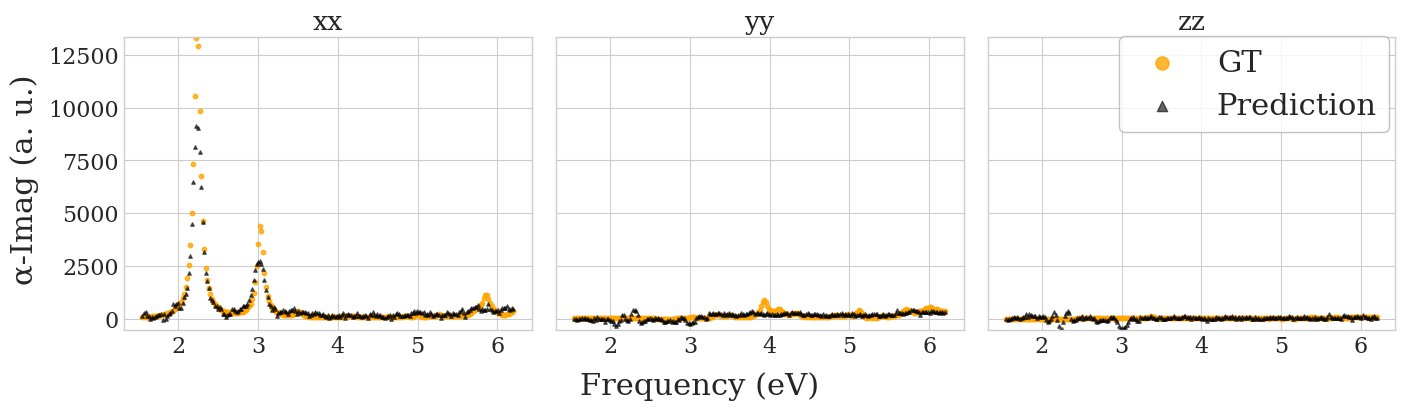

242 241 241
242 241 241
242 241 241


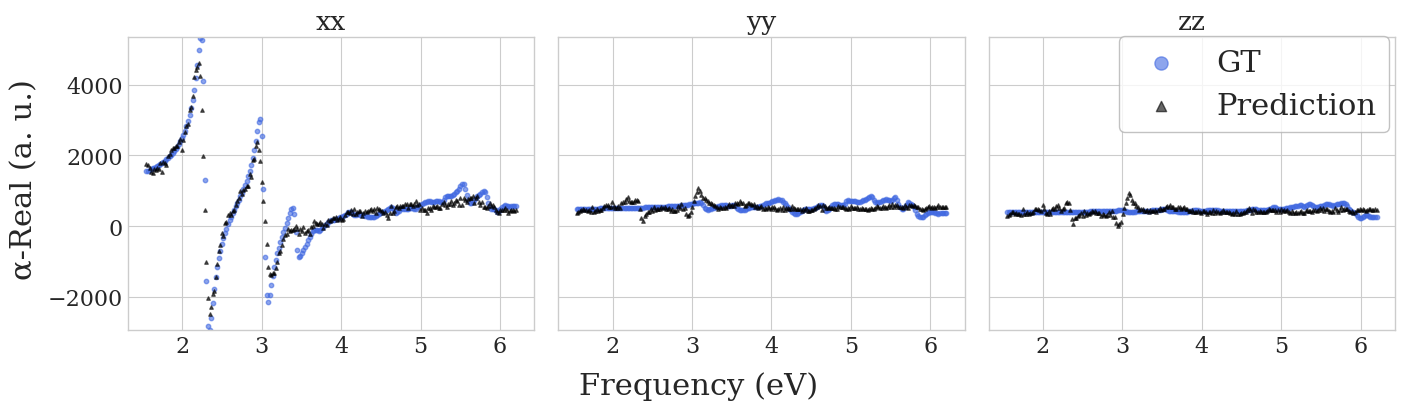

imag 242 241 241
imag 242 241 241
imag 242 241 241


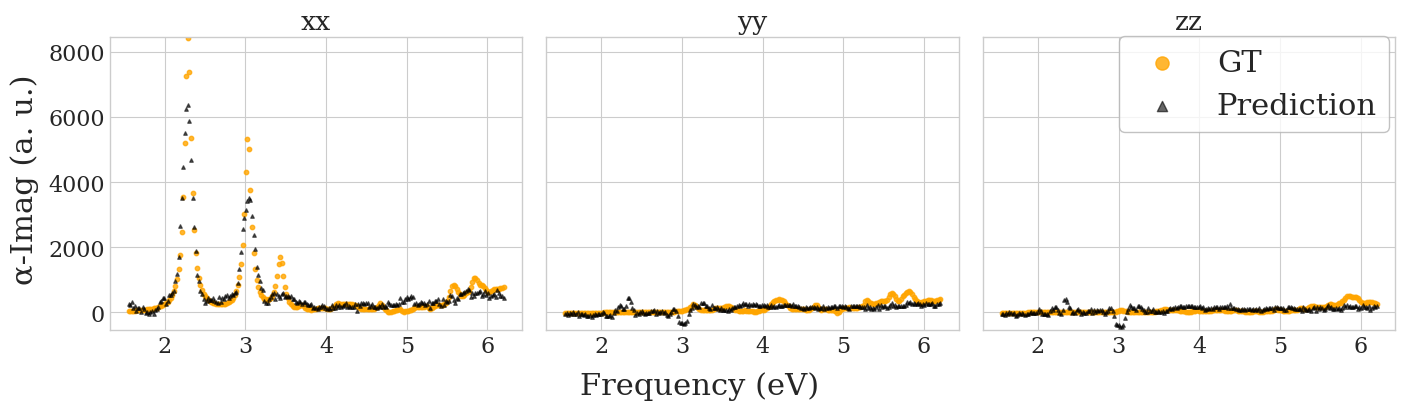

242 241 241
242 241 241
242 241 241


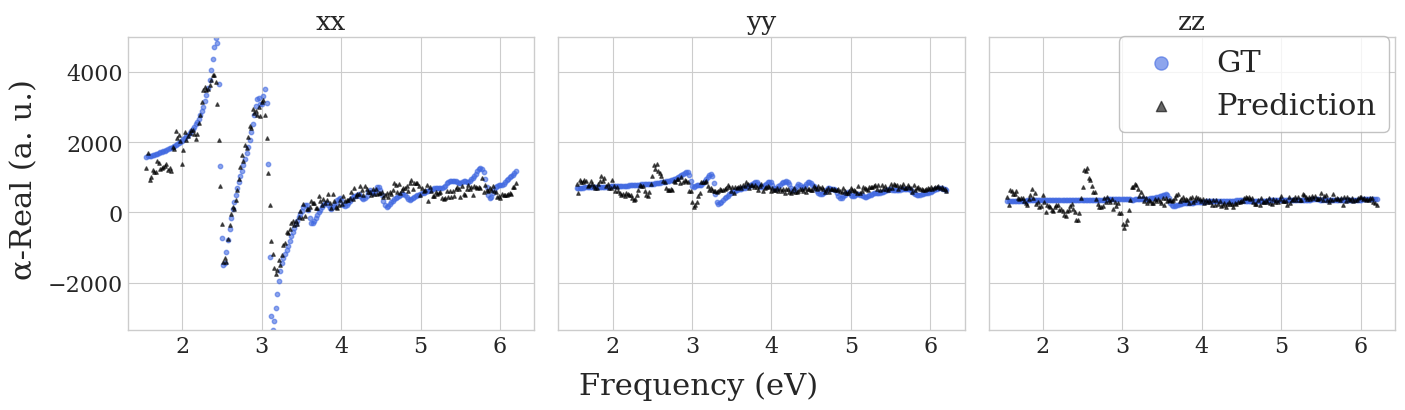

imag 242 241 241
imag 242 241 241
imag 242 241 241


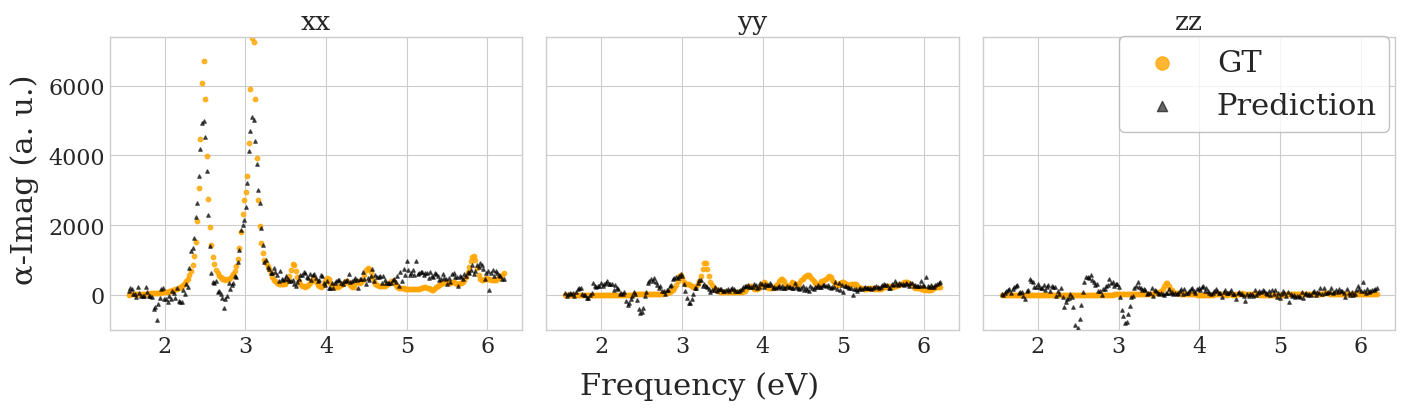

242 241 241
242 241 241
242 241 241


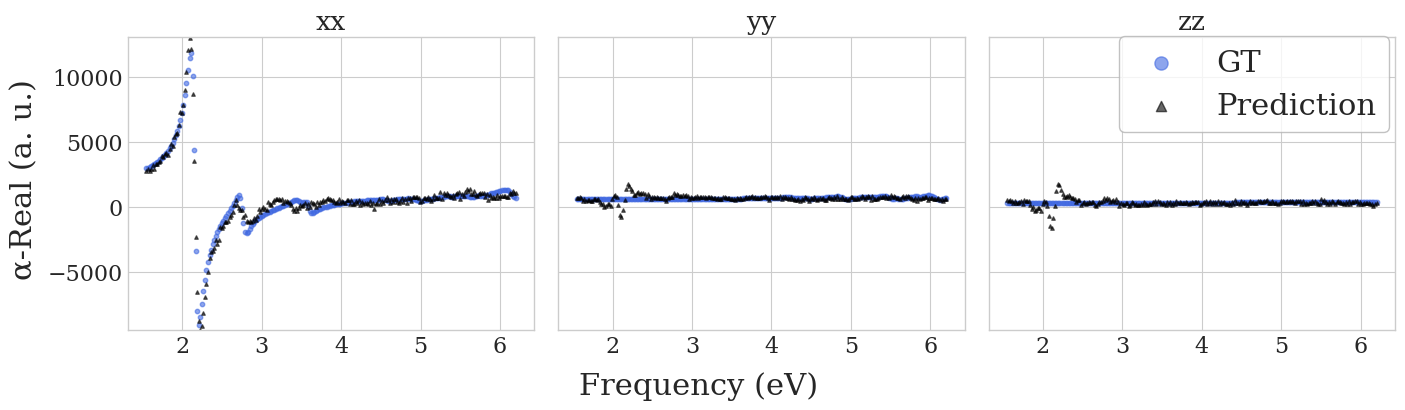

imag 242 241 241
imag 242 241 241
imag 242 241 241


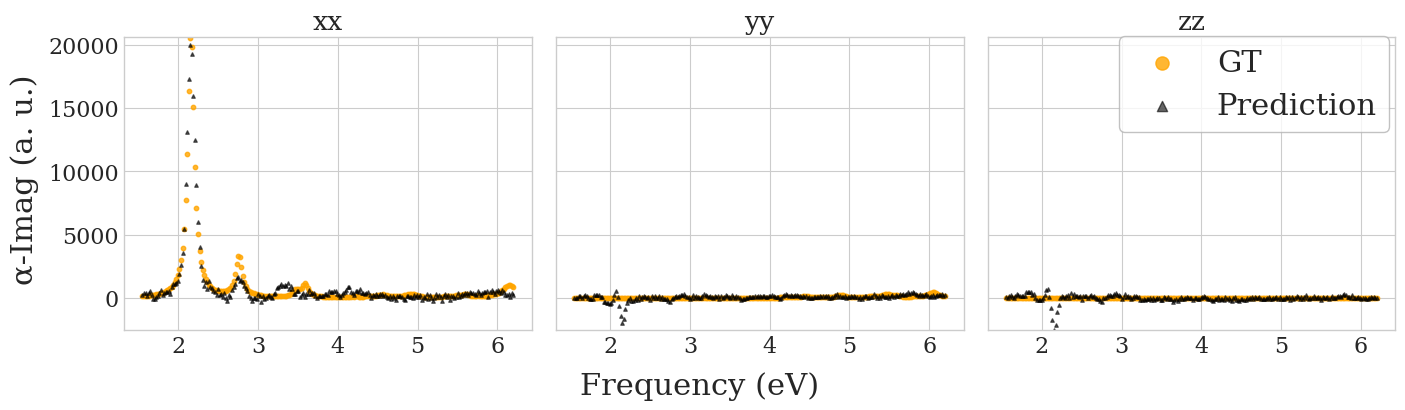

In [5]:
for i in range(4):
    data_entry = val_datasets[i]  # Assuming you want to plot the first entry
    plot_polarizability_elements(data_entry ,model, out_dir="/home/maria/dyn-detanet/images")

Flattened samples = 151830
Flattened samples predictions = 151830


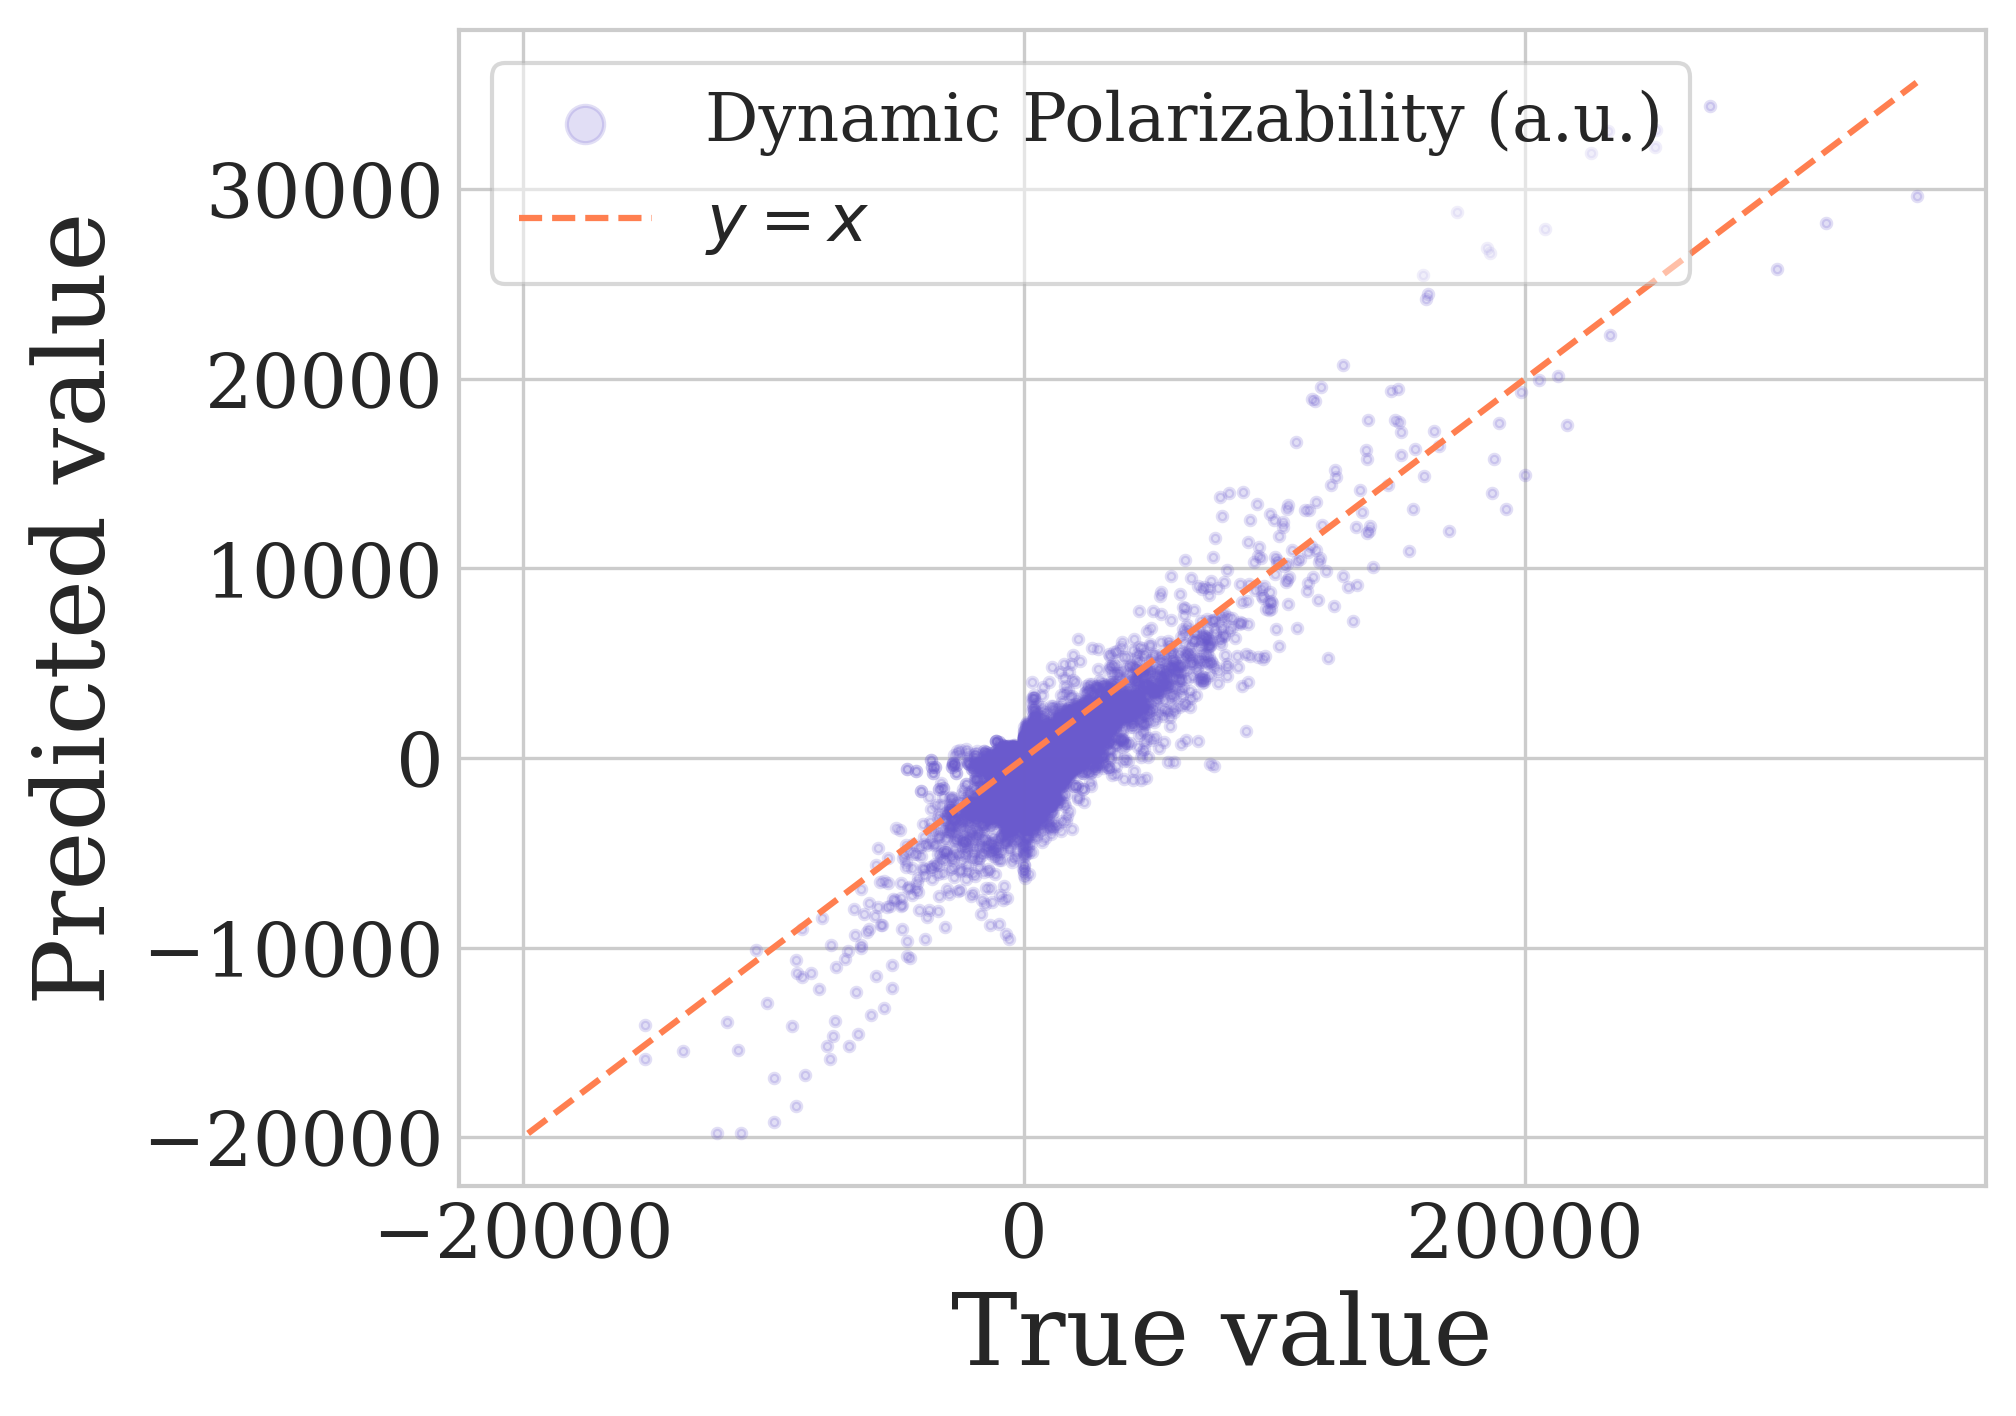

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from detanet_model import R2
from sklearn.metrics import r2_score, mean_absolute_error



# create a copy of the validation datasets
val_dataset_plot = [data.clone() for data in val_datasets]

for data_entry in val_dataset_plot:
    data_entry.real_ee = data_entry.real_ee[1:]  # remove static frequency
    data_entry.imag_ee = data_entry.imag_ee[1:]  # remove static frequency
    data_entry.y = torch.cat([data_entry.real_ee, data_entry.imag_ee], dim=0)  # [N, 6]


# 1. Validation DataLoader
val_loader = DataLoader(val_dataset_plot, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model   = model.to(device).eval()

true_vals, pred_vals = [], []

with torch.no_grad():
    for batch in val_loader:
        # a) ground-truth: flatten everything to 1-D
        true_vals.append(batch.y.cpu().view(-1))

        # b) prediction
        pred = model(
            z=batch.z.to(device),
            pos=batch.pos.to(device),
            x_features=batch.x.to(device)
        )

        # pred might already be numpy; make sure we flatten on CPU
        if isinstance(pred, torch.Tensor):
            pred_flat = pred.cpu().view(-1)
        else:
            pred_flat = torch.tensor(pred).view(-1)

        pred_vals.append(pred_flat)

# stack into single 1-D vectors
true_vals = torch.cat(true_vals).numpy()
pred_vals = torch.cat(pred_vals).numpy()

print("Flattened samples =", true_vals.size)   # total number of values
print("Flattened samples predictions =", pred_vals.size)   # total number of values




import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")  # 1) global style
plt.rcParams.update({                    # 2) fine-tune fonts
    "font.family": "serif",
    "font.serif":  ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],
    "font.size":        16,   # default text size
    "axes.labelsize":   24,   # x/y/z axis labels
    "axes.titlesize":   18,   # figure / axes titles
    "xtick.labelsize":  18,   # x-axis tick labels
    "ytick.labelsize":  18,   # y-axis tick labels
    "legend.fontsize":  16,   # legend text
})



# 2. Scatter plot
plt.figure(figsize=(7, 5),dpi=300)
plt.scatter(true_vals, pred_vals, c="slateblue", s=5, alpha=0.2, label="Dynamic Polarizability (a.u.)")

vmin, vmax = min(true_vals.min(), pred_vals.min()), max(true_vals.max(), pred_vals.max())
plt.plot([vmin, vmax], [vmin, vmax], "--", color="coral", label="$y=x$")

plt.xlabel("True value")
plt.ylabel("Predicted value")
#plt.title("Validation: Flattened Predicted vs. True")
plt.legend(
    frameon=True,
    facecolor="white",
    edgecolor="0.7",
    framealpha=0.5,
    markerscale=4.0
)

plt.grid(True)
plt.tight_layout()

plt.show()
